In [177]:
#Components to help with our OLS analysis
import pandas as pd
import numpy as np
import scipy.stats as sp
import seaborn as sns
import statsmodels.regression.linear_model
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices


## Is the SAT or ACT Better for High Schoolers to Take? - A Regression Analysis


---

This jupyter notebook explores whether high schools should direct students towards taking the ACT or SAT exam. We will assess which one has a stronger causal effect for long-term academic success, while holding other causal factors constant. Our measure of long term success will be the percentage of high school students who graduate from college at least six years after high school. To conduct this analysis, we will utilize ordinary least squares (OLS), creating 3 different models. 

### Ordinary Least Squares Overview

OLS aims to estimate the effect that a number of factors, also called regressors, have on an outcome. To do so, it minimizes the sum of the squared differences between the observed values of the dependent variable (here, the pct. of HS students who graduate from college at least 6 years after high school) and the predicted values based on the linear function created with the independent variables (here, the regressors that affect the percentage of HS students later graduating college). 

The following is the OLS linear function that is created to make predictions for the dependent variable $Y$. 

$Y = \beta_0 + \sum_{i=1}^n \beta_{i}x_i + \epsilon$

$\beta_0$ represents the initial value for the dependent variable $Y$. Each regressor $x_i$has a $\beta_i$ to represent the effect that it has on $Y$ when all other regressors are held constant. The statsmodels.regression.linear_model component will use matrice algebra to optimize the $\beta_i$s for each factor in the linear function. The statsmodels component is very helpful in this case, since we will be dealing with a large amount of regressors. This component will free us from conducting tedious linear algebra work to find the linear function.

$\epsilon$, the error term, takes into account the unobserved factors affecting our model. The statsmodels component calculates this using the residuals.

### What Makes A Great OLS Model?

Great OLS models minimize endogeneity and maximize exogeneity. Endogeneity arises from regressors, $x_i$, that influence $Y$ yet also are inversely influenced by $Y$. We wish to minimize this as we aim to select regressors that have a one-way causal affect on $Y$. These are exogenious regressors.

Great models minimize the effect that the $\epsilon$, the error term, has on the final prediction. To minimize the error term, data scientists aim to have the errors be normally distributed with zero as their mean and to have them be homoskedastic. We can measure the normality of the distribution of the errors by finding its skewness. Skewness measures the lack of symmetry that revolves around the average of an array. If an array of data is normally distributed, it is symmetrical and has skewness of 0. The following describes skewness, where $x_i$ is an observation, $\hat{x}$ is the mean of the array, $N$ is the number of values, and $\sigma$ is the std. deviation of the data: 

Skewness = $\frac{\sum_{i}^N(X_i - \hat{X})^3}{(N-1)\sigma^3}$

Great models typically have a generally high coefficient of determination, $R^2$. This statistic informs us of the proportion of dependent variable's variation that can be understood from the provided regressors. It ranges between 0 and 1. The following is the calculation for $R^2$, where $SS_{res}$ is the residual sum of squaress and $SS_{tot}$ is the total sum of squares

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$

It's also important to have regressors that not highly correlated with one another. Here, we are minimizing what is called multicollinearity. If regressors are heavily related, then it can be difficult for the model to accurately depict the effect a change in just one regressor has on the prediction. A common measure of multicollinearity is the variance inflation factor (VIF). VIF is the degree to which the an estimated regression coefficient's variance is inaccurate due to multicollinearity. The calculation of VIF for a regressor,$x_i$ follows:

$VIF_i = \frac{1}{1-R_{i}^2}$

In the above, $R_{i}^2$ is the coefficeint of determination found when $x_{i}$ is regressed against all other regressors. A VIF of 1 indicates there is no multicollinearity, a VIF between 1 and 5 indicates moderate multicollinearity, and a VIF greater than 5 indicates high multicollinearity.
We will create a custom function to help us calculate VIF, using statsmodels' variance_inflation_factor method.

In [178]:
""""function to calculate VIFs for each regressor
    in regression and present multicollinearity intensity"""
def vif_finder(regression, dataset):
    #obtain design matrix
    Y, X = dmatrices(regression,
                    data = dataset, return_type = 'dataframe')
    
    #calculate vifs
    vif_results = pd.DataFrame()
    vifs = []
    for i in range(X.shape[1]):
        vifs.append(variance_inflation_factor(X.values, i))
    vif_results['VIF'] = vifs
    vif_results['regressor'] = X.columns
    
    #Categorize vifs by intensity 
    vif_categories = []
    for i in range(X.shape[1]):
        if (vif_results.loc[i,'VIF'] == 1):
            vif_categories.append("No MultiColl.")
        elif (vif_results.loc[i,'VIF'] > 1 and vif_results.loc[i,'VIF'] <= 5):
            vif_categories.append("Moderate MultiColl.")
        else:
            vif_categories.append("High MultiColl.")
    vif_results['Multicollinearity'] = vif_categories
    
    #return count of vifs that show no, moderate, or high multicollinearity
    vif_intensities = vif_results['Multicollinearity'].value_counts()
    
    #return vifs
    return vif_intensities

Lastly, the dataset we are working with must be a representative sample of the population of interest. More details on this project's dataset is below.

### How I Approached the Data

The paper’s dataset focuses on public school data from the state of Ohio during the 2010’s. As a student at The Ohio State University, this data was accessible and relatively easy to obtain. This dataset can be found in the github repository. Since my analysis focuses on whether students from the high school class of 2011 graduated college within 6 years, I aimed to select high school data from years nearest to 2011. I limited the number of observations from 609 to 460 due to certain Ohio schools having missing data. The dataset is stored within an excel file, where it is separated into three sheets: “General” for mainly socioeconomic data of the countyr each school resides in, “Classes” for the academic rigor each school offers, and “Success” for specific information on student achievement for each school.  


### Background Insight Regarding the SAT and ACT

The SAT and ACT, developed by the non-profit organizations, ACT, Inc. and College Board respectively, test high schoolers in math, reading, grammar, and science. The two exams test a mix between knowledge and cognition. According to ACT Inc. and College Board data, 1.35 million high school seniors took the ACT versus 1.7 million who took the SAT. As of 2023, it costs 64.60 dollars to take the SAT with the essay portion versus 67 dollars to take the ACT with the writing portion. 


### Loading The Data

In [179]:
#Array of names for each column in dataset
column_names = ["DistrictIRN", "DistrictName", "County", 
                "PerformanceIndexScore201516", "Typology", "Enrollment1112",
                "MedianIncome2010", "StudentPoverty", "PctMinority1112", 
                "PctWithProfessionalOccupation", "PctofPopwithLeastaBach", 
                "TeacherAttendanceRate", "TeacherAvgSalary", "TeacherAvgYrsExperience",
                "PctTchAtLeastBachelors", "PctTchAtLeastMasters", "PctInexperiencedTchrs",
               "PctHSCreditAlgebraByGrade8", "PctHSCreditManySubjectsByGrade8", 
                "PctMiddleSchool3CreditsManySub", "PctHSCreditAlgebraByGrade9", 
                "Pct5HSCreditsManySubjectsBy9", "PctHSCreditAlgebraIIByGrade11",
               "PctOf2011GraduateCollege", "Pct2013ActParticipation", "ACTMeanScoreClassOf2013",
               "PctClass2013ActRemediationFree", "PctClass2013SATParticipaton",
               "SATMeanScoreClassOf2013", "Num2013SatRemediationFree", 
                "PctClass2013SATRemediationFree", "PctHSGraduatingHonors2013", 
               "PctHSGraduatingIndCred2013", "PctClass2013InAPs", 
                "Pct2013ScoreOf3OrMoreAP", "Pct2013AtLeast3DualEnrollment"]

#Import Excel Dataset and assign column names from array
ohio_schools_df = pd.read_excel('/Users/dominickyacono/Downloads/School_Data_Ohio.xlsx', names = column_names)

In [160]:
#Quick look at columns and number of entries in dataset
ohio_schools_df

,DistrictIRN,DistrictName,County,PerformanceIndexScore201516,Typology,Enrollment1112,MedianIncome2010,StudentPoverty,PctMinority1112,PctWithProfessionalOccupation,...,PctClass2013ActRemediationFree,PctClass2013SATParticipaton,SATMeanScoreClassOf2013,Num2013SatRemediationFree,PctClass2013SATRemediationFree,PctHSGraduatingHonors2013,PctHSGraduatingIndCred2013,PctClass2013InAPs,Pct2013ScoreOf3OrMoreAP,Pct2013AtLeast3DualEnrollment
0,43489,Akron City,Summit,65.906,8,22602.889954,24324,0.846992,0.563808,0.531155,...,10.4,2.7,1112,25,1.6,4.2,6.3,12.4,6.5,2.5
1,43497,Alliance City,Stark,72.322,7,2859.185954,22824,0.770174,0.292796,0.494013,...,13.6,1.4,1090,1,0.5,8.6,16.4,9.5,13.2,0.0
2,43505,Ashland City,Ashland,86.009,4,3465.865966,27964,0.375894,0.071093,0.516940,...,27.5,4.2,1144,10,3.8,16.0,5.0,13.7,22.1,1.9
3,43513,Ashtabula Area City,Ashtabula,71.076,4,3936.109430,24918,0.713338,0.304642,0.478853,...,10.6,2.2,1058,2,0.7,11.7,14.2,16.1,10.2,7.3
4,43521,Athens City,Athens,86.594,5,2756.823484,26301,0.340554,0.082480,0.612160,...,30.6,37.3,1140,49,25.4,18.7,2.1,0.0,32.1,14.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,50682,Elmwood Local,Wood,85.734,2,1248.452304,32684,0.381457,0.048100,0.398204,...,20.8,2.1,1260,2,2.1,21.9,5.2,0.0,0.0,3.1
456,50724,Otsego Local,Wood,84.291,3,1601.980594,38815,0.283875,0.080164,0.590758,...,18.9,2.5,1080,1,0.8,14.8,9.8,0.0,1.6,2.5
457,50740,Mohawk Local,Wyandot,87.015,2,921.597487,32142,0.282983,0.013070,0.485770,...,27.5,8.7,1058,5,7.2,33.3,21.7,18.8,5.8,14.5
458,61903,Adams County Ohio Valley Local,Adams,77.851,1,3962.162989,25268,0.643098,0.019289,0.483544,...,9.6,0.6,1056,2,0.6,6.4,0.0,0.3,0.0,23.2


### The Empirical Results and Conclusions

For my models, a regressor is significant if its $P$ value ≤ 0.1. 
The $P$ value is the probability of observing the regressor's coefficient (or a more extreme coefficient) if the regressor's effect on the prediction is hypothetically 0. Therefore, very low $P$ values are attractive.

#### First Model

First, I create a general regression model with as many regressors that I believed were important to tackling the problem. For the school district typology regressor, I transform it into dummy variables since it is categorical. The first general regression follows with \$R^2$= 0.852. There are 25 regressors with moderate multicollinearity and 14 regressors with high multicollinearity. The distribution of our model's errors has a skewness of 0.14.

In [161]:
#OLS model
first_model = ols('PctOf2011GraduateCollege ~ PerformanceIndexScore201516 + C(Typology) + Enrollment1112 + MedianIncome2010 + StudentPoverty + PctMinority1112 + PctWithProfessionalOccupation + PctofPopwithLeastaBach + TeacherAttendanceRate + TeacherAvgSalary + TeacherAvgYrsExperience + PctTchAtLeastBachelors + PctTchAtLeastMasters + PctInexperiencedTchrs + PctHSCreditAlgebraByGrade8 + PctHSCreditManySubjectsByGrade8  + PctMiddleSchool3CreditsManySub + PctHSCreditAlgebraByGrade9 + Pct5HSCreditsManySubjectsBy9 + PctHSCreditAlgebraIIByGrade11 + Pct2013ActParticipation + ACTMeanScoreClassOf2013 + PctClass2013ActRemediationFree + PctClass2013SATParticipaton + SATMeanScoreClassOf2013 + Num2013SatRemediationFree+ PctClass2013SATRemediationFree + PctHSGraduatingHonors2013+ PctHSGraduatingIndCred2013 + PctClass2013InAPs + Pct2013ScoreOf3OrMoreAP + Pct2013AtLeast3DualEnrollment', 
                 data = ohio_schools_df).fit()

In [180]:
""""Calculate and view number of regressors degree 
with no, moderate, and high multicollinearity"""
vifs = vif_finder('PctOf2011GraduateCollege ~ PerformanceIndexScore201516 + C(Typology) + Enrollment1112 + MedianIncome2010 + StudentPoverty + PctMinority1112 + PctWithProfessionalOccupation + PctofPopwithLeastaBach + TeacherAttendanceRate + TeacherAvgSalary + TeacherAvgYrsExperience + PctTchAtLeastBachelors + PctTchAtLeastMasters + PctInexperiencedTchrs + PctHSCreditAlgebraByGrade8 + PctHSCreditManySubjectsByGrade8  + PctMiddleSchool3CreditsManySub + PctHSCreditAlgebraByGrade9 + Pct5HSCreditsManySubjectsBy9 + PctHSCreditAlgebraIIByGrade11 + Pct2013ActParticipation + ACTMeanScoreClassOf2013 + PctClass2013ActRemediationFree + PctClass2013SATParticipaton + SATMeanScoreClassOf2013 + Num2013SatRemediationFree+ PctClass2013SATRemediationFree + PctHSGraduatingHonors2013+ PctHSGraduatingIndCred2013 + PctClass2013InAPs + Pct2013ScoreOf3OrMoreAP + Pct2013AtLeast3DualEnrollment', ohio_schools_df)
vifs

Moderate MultiColl.    25
High MultiColl.        14
Name: Multicollinearity, dtype: int64

In [163]:
#Generate table summary of regression
first_model.summary(title = "First Model Results")

<class 'statsmodels.iolib.summary.Summary'>
"""
                                First Model Results                                 
====================================================================================
Dep. Variable:     PctOf2011GraduateCollege   R-squared:                       0.852
Model:                                  OLS   Adj. R-squared:                  0.839
Method:                       Least Squares   F-statistic:                     63.81
Date:                      Fri, 12 May 2023   Prob (F-statistic):          2.57e-150
Time:                              15:56:53   Log-Likelihood:                -1419.9
No. Observations:                       460   AIC:                             2918.
Df Residuals:                           421   BIC:                             3079.
Df Model:                                38                                         
Covariance Type:                  nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           4.8780     15.794      0.309      0.758     -26.166      35.922
C(Typology)[T.2]                    1.7266      1.062      1.625      0.105      -0.361       3.815
C(Typology)[T.3]                   -0.2441      1.124     -0.217      0.828      -2.454       1.966
C(Typology)[T.4]                   -0.6535      1.089     -0.600      0.549      -2.794       1.487
C(Typology)[T.5]                    0.9917      1.603      0.619      0.537      -2.160       4.143
C(Typology)[T.6]                    3.1949      2.704      1.181      0.238      -2.121       8.511
C(Typology)[T.7]                    0.7304      1.590      0.459      0.646      -2.395       3.856
C(Typology)[T.8]                    0.7361      4.149      0.177      0.859      -7.419       8.892
PerformanceIndexScore201516         0.1676      0.064      2.600      0.010       0.041       0.294
Enrollment1112                     -0.0001      0.000     -0.789      0.431      -0.000       0.000
MedianIncome2010                   -0.0002   8.81e-05     -2.705      0.007      -0.000   -6.51e-05
StudentPoverty                    -26.5511      4.220     -6.292      0.000     -34.845     -18.257
PctMinority1112                     2.1478      2.985      0.720      0.472      -3.720       8.015
PctWithProfessionalOccupation      -7.2281      7.312     -0.988      0.323     -21.601       7.145
PctofPopwithLeastaBach             20.1947      7.493      2.695      0.007       5.467      34.923
TeacherAttendanceRate               0.0915      0.056      1.645      0.101      -0.018       0.201
TeacherAvgSalary                -6.443e-05   5.82e-05     -1.107      0.269      -0.000       5e-05
TeacherAvgYrsExperience             0.3019      0.125      2.416      0.016       0.056       0.548
PctTchAtLeastBachelors             -0.0090      0.082     -0.109      0.913      -0.171       0.153
PctTchAtLeastMasters                0.0288      0.030      0.960      0.337      -0.030       0.088
PctInexperiencedTchrs               0.0178      0.038      0.472      0.637      -0.056       0.092
PctHSCreditAlgebraByGrade8         -1.5366      2.107     -0.729      0.466      -5.679       2.605
PctHSCreditManySubjectsByGrade8     0.8960      1.290      0.694      0.488      -1.640       3.432
PctMiddleSchool3CreditsManySub      0.6567      1.607      0.409      0.683      -2.502       3.815
PctHSCreditAlgebraByGrade9          0.4549      1.322      0.344      0.731      -2.143       3.053
Pct5HSCreditsManySubjectsBy9        0.6170      1.384      0.446      0.656      -2.104       3.338
PctHSCreditAlgebraIIByGrade11      -0.6866      1.549     -0.443      0.658      -3.732       2.358
Pct2013ActPartici

Skewness:  0.14159346665729747


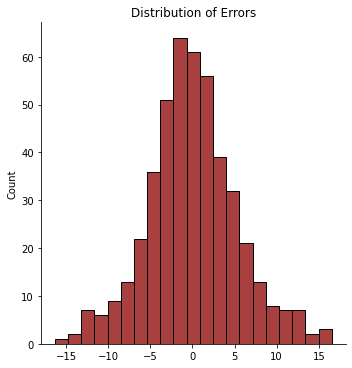

In [174]:
#obtain model residuals
model_residuals = first_model.resid

#plot residuals and find skew
sns.displot(model_residuals,kde = False, color = "darkred").set(title = "Distribution of Errors")
print("Skewness: ", model_residuals.skew())

#### Second Model

Analyzing the first model, I recognize a number of changes to make. **PctWithProfessionalOccupation** is not statistically significant (P-value = 0.3), and is an ambiguous term that likely covers a population already covered by the **PctofPopwithLeastaBach** variable, which might lead to multicollinearity. Six regressors regarding teachers is unnecessary, as some of them are closely related. Therefore, I cut down the number of insignificant regressors. I carry out the same process on regressors regarding credits and coursework taken, as many of them are very related and also insignificant. Since the **Typology** dummy variables covered urban density and poverty (both also covered by the **Enrollment1112** and **StudentPoverty** variables), I removed them.

In [165]:
second_model = ols('PctOf2011GraduateCollege ~ PerformanceIndexScore201516 + Enrollment1112 + MedianIncome2010 + StudentPoverty + PctMinority1112 + PctofPopwithLeastaBach + TeacherAttendanceRate + TeacherAvgSalary + TeacherAvgYrsExperience + PctHSCreditAlgebraByGrade8 + PctHSCreditManySubjectsByGrade8  + Pct2013ActParticipation + ACTMeanScoreClassOf2013 + PctClass2013ActRemediationFree + PctClass2013SATParticipaton + SATMeanScoreClassOf2013 + Num2013SatRemediationFree + PctClass2013SATRemediationFree + PctHSGraduatingHonors2013 + PctHSGraduatingIndCred2013 + PctClass2013InAPs + Pct2013ScoreOf3OrMoreAP + Pct2013AtLeast3DualEnrollment', 
                 data = ohio_schools_df).fit()

In [166]:
""""Calculate and view number of regressors degree 
with no, moderate, and high multicollinearity"""
vifs = vif_finder('PctOf2011GraduateCollege ~ PerformanceIndexScore201516 + Enrollment1112 + MedianIncome2010 + StudentPoverty + PctMinority1112 + PctofPopwithLeastaBach + TeacherAttendanceRate + TeacherAvgSalary + TeacherAvgYrsExperience + PctHSCreditAlgebraByGrade8 + PctHSCreditManySubjectsByGrade8  + Pct2013ActParticipation + ACTMeanScoreClassOf2013 + PctClass2013ActRemediationFree + PctClass2013SATParticipaton + SATMeanScoreClassOf2013 + Num2013SatRemediationFree + PctClass2013SATRemediationFree + PctHSGraduatingHonors2013 + PctHSGraduatingIndCred2013 + PctClass2013InAPs + Pct2013ScoreOf3OrMoreAP + Pct2013AtLeast3DualEnrollment', ohio_schools_df)
vifs

Moderate MultiColl.    13
High MultiColl.        11
Name: Multicollinearity, dtype: int64

In [167]:
second_model.summary(title = "Second Model Results")

<class 'statsmodels.iolib.summary.Summary'>
"""
                                Second Model Results                                
====================================================================================
Dep. Variable:     PctOf2011GraduateCollege   R-squared:                       0.848
Model:                                  OLS   Adj. R-squared:                  0.840
Method:                       Least Squares   F-statistic:                     105.6
Date:                      Fri, 12 May 2023   Prob (F-statistic):          3.97e-162
Time:                              15:56:54   Log-Likelihood:                -1426.4
No. Observations:                       460   AIC:                             2901.
Df Residuals:                           436   BIC:                             3000.
Df Model:                                23                                         
Covariance Type:                  nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           7.8746     13.773      0.572      0.568     -19.196      34.945
PerformanceIndexScore201516         0.1689      0.063      2.667      0.008       0.044       0.293
Enrollment1112                  -9.713e-05    8.8e-05     -1.104      0.270      -0.000    7.57e-05
MedianIncome2010                   -0.0002   7.85e-05     -2.562      0.011      -0.000   -4.69e-05
StudentPoverty                    -27.1535      3.862     -7.032      0.000     -34.743     -19.564
PctMinority1112                     2.2533      2.776      0.812      0.417      -3.203       7.709
PctofPopwithLeastaBach             15.6427      4.990      3.135      0.002       5.835      25.451
TeacherAttendanceRate               0.0883      0.041      2.134      0.033       0.007       0.170
TeacherAvgSalary                -5.025e-05   5.21e-05     -0.965      0.335      -0.000    5.21e-05
TeacherAvgYrsExperience             0.3156      0.094      3.354      0.001       0.131       0.500
PctHSCreditAlgebraByGrade8         -1.8389      1.995     -0.922      0.357      -5.760       2.082
PctHSCreditManySubjectsByGrade8     1.2144      1.186      1.024      0.307      -1.117       3.546
Pct2013ActParticipation             0.1681      0.049      3.463      0.001       0.073       0.263
ACTMeanScoreClassOf2013             0.0921      0.509      0.181      0.856      -0.907       1.092
PctClass2013ActRemediationFree      0.2175      0.086      2.521      0.012       0.048       0.387
PctClass2013SATParticipaton         0.1019      0.107      0.956      0.340      -0.108       0.311
SATMeanScoreClassOf2013            -0.0033      0.004     -0.930      0.353      -0.010       0.004
Num2013SatRemediationFree           0.0045      0.011      0.398      0.691      -0.018       0.026
PctClass2013SATRemediationFree     -0.0531      0.163     -0.326      0.744      -0.373       0.267
PctHSGraduatingHonors2013           0.0754      0.044      1.697      0.090      -0.012       0.163
PctHSGraduatingIndCred2013         -0.0892      0.039     -2.296      0.022      -0.166      -0.013
PctClass2013InAPs                  -0.0316      0.019     -1.645      0.101      -0.069       0.006
Pct2013ScoreOf3OrMoreAP             0.0407      0.023      1.789      0.074      -0.004       0.085
Pct2013AtLeast3DualEnrollment       0.0219      0.028      0.768      0.443      -0.034       0.078
==============================================================================
Omnibus:                        6.768   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                8.518
Skew:                           0.141   Prob(JB):                       0.0141
K

Skewness:  0.14174156195866103


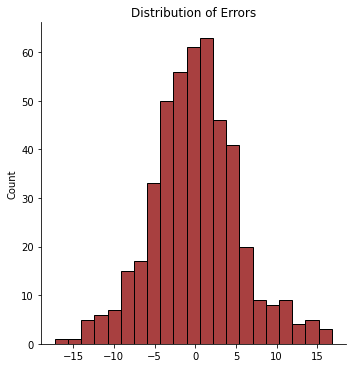

In [175]:
#obtain model residuals
second_model_residuals = second_model.resid

#plot residuals and find skew
sns.displot(second_model_residuals,kde = False, color = "darkred").set(title = "Distribution of Errors")
print("Skewness: ", second_model_residuals.skew())

The second regression, with 11 less regressors, results in the same \$R^2$ value as the first regression (0.85), and with 11 statistically significant coefficients compared to 10 before. Our skewness is the same. There are now 13 regressors with moderate multicollinearity vs. 25 before and 11 regressors with high multicollinearity vs. 14 before.

This is a substantial improvement from the previous model. We removed non-significant regressors that were heavily related to one another and produced a regression with the same $R^2$! 

#### Final Model

As I prepare the final regression, I analyze a few more changes to make to my second model. To avoid multicollinearity,  I remove some more related regressors. Interested in the combined effect of **PctMinority1112** and **StudentPoverty**, I add an interaction term to my final regression. An interaction term describes the multiplicative effect of two regressors on a model. Here, although high school student poverty levels surely affect long-term college graduation rates, I am interested in whether there is an even more dramatic effect when racial demographics are taken into consideration. 


In [169]:
final_model = ols('PctOf2011GraduateCollege ~ PerformanceIndexScore201516 + Enrollment1112 + MedianIncome2010 + StudentPoverty + PctMinority1112 + PctofPopwithLeastaBach + TeacherAttendanceRate + TeacherAvgSalary + TeacherAvgYrsExperience + PctHSCreditAlgebraByGrade8 + PctHSCreditManySubjectsByGrade8 + Pct2013ActParticipation + ACTMeanScoreClassOf2013 + PctClass2013SATParticipaton + SATMeanScoreClassOf2013 + PctHSGraduatingHonors2013 + PctHSGraduatingIndCred2013 + PctClass2013InAPs + Pct2013ScoreOf3OrMoreAP + Pct2013AtLeast3DualEnrollment + StudentPoverty:PctMinority1112', 
                 data = ohio_schools_df).fit()

As mentioned earlier, it's important for a regression model to minimize the heteroskedascity of its errors. Minimizing the heteroskedascity of errors essentially means lowering their variance between them. Nobody wants to have a prediction that is for one observation very close to the actual value and for another is completely off!

If error heteroskedascity is not taken care of, regressor coefficients might have inaccurate confidence intervals  To take into account heteroskedascity into our model, we can have robust standard errors. Robust standard errors adjust the standard errors and therefore change the confidence intervals to accurately reflect the variable uncertainity in the model.

To analyze my model's heteroskedacity, I will create a scatter plot of the relationship between each predicted value and its corresponding error size. If their is an observable trend (ex: error size increasing as predicted value increases), then we can say heteroskedascity is prominent in the errors and I will apply robust standard errors.

<AxesSubplot:>

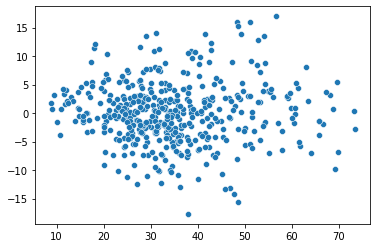

In [170]:
#obtain residuals
residuals = final_model.resid

#obtain predictions from linear function generated
predictions = final_model.predict()

#scatter plot of predictions vs residuals
sns.scatterplot(x=predictions, y = residuals)

There does not appear to be significant heteroskedascity, therefore we will not apply robust standard errors. We will continue with our current model.

In [171]:
""""Calculate and view number of regressors degree 
with no, moderate, and high multicollinearity"""
vifs_final = vif_finder('PctOf2011GraduateCollege ~ PerformanceIndexScore201516 + Enrollment1112 + MedianIncome2010 + StudentPoverty + PctMinority1112 + PctofPopwithLeastaBach + TeacherAttendanceRate + TeacherAvgSalary + TeacherAvgYrsExperience + PctHSCreditAlgebraByGrade8 + PctHSCreditManySubjectsByGrade8 + Pct2013ActParticipation + ACTMeanScoreClassOf2013 + PctClass2013SATParticipaton + SATMeanScoreClassOf2013 + PctHSGraduatingHonors2013 + PctHSGraduatingIndCred2013 + PctClass2013InAPs + Pct2013ScoreOf3OrMoreAP + Pct2013AtLeast3DualEnrollment + StudentPoverty:PctMinority1112', ohio_schools_df)
vifs_final

Moderate MultiColl.    13
High MultiColl.         9
Name: Multicollinearity, dtype: int64

In [172]:
final_model.summary(title = "Final Model Results")

<class 'statsmodels.iolib.summary.Summary'>
"""
                                Final Model Results                                 
====================================================================================
Dep. Variable:     PctOf2011GraduateCollege   R-squared:                       0.848
Model:                                  OLS   Adj. R-squared:                  0.840
Method:                       Least Squares   F-statistic:                     116.1
Date:                      Fri, 12 May 2023   Prob (F-statistic):          4.31e-164
Time:                              15:56:54   Log-Likelihood:                -1426.7
No. Observations:                       460   AIC:                             2897.
Df Residuals:                           438   BIC:                             2988.
Df Model:                                21                                         
Covariance Type:                  nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                         -14.8621     10.088     -1.473      0.141     -34.689       4.965
PerformanceIndexScore201516         0.1922      0.063      3.041      0.002       0.068       0.316
Enrollment1112                     -0.0001   7.84e-05     -1.643      0.101      -0.000    2.53e-05
MedianIncome2010                   -0.0002   7.75e-05     -2.453      0.015      -0.000   -3.78e-05
StudentPoverty                    -29.3679      3.843     -7.642      0.000     -36.920     -21.815
PctMinority1112                    -9.5425      5.960     -1.601      0.110     -21.257       2.172
PctofPopwithLeastaBach             17.9097      5.118      3.499      0.001       7.851      27.969
TeacherAttendanceRate               0.0843      0.041      2.036      0.042       0.003       0.166
TeacherAvgSalary                -4.139e-05   5.21e-05     -0.795      0.427      -0.000    6.09e-05
TeacherAvgYrsExperience             0.3091      0.094      3.297      0.001       0.125       0.493
PctHSCreditAlgebraByGrade8         -2.0303      1.993     -1.019      0.309      -5.948       1.887
PctHSCreditManySubjectsByGrade8     1.2241      1.183      1.035      0.301      -1.100       3.548
Pct2013ActParticipation             0.2266      0.038      6.025      0.000       0.153       0.301
ACTMeanScoreClassOf2013             1.0904      0.353      3.092      0.002       0.397       1.783
PctClass2013SATParticipaton         0.0664      0.040      1.674      0.095      -0.012       0.144
SATMeanScoreClassOf2013            -0.0028      0.003     -0.852      0.395      -0.009       0.004
PctHSGraduatingHonors2013           0.0978      0.043      2.259      0.024       0.013       0.183
PctHSGraduatingIndCred2013         -0.0897      0.039     -2.318      0.021      -0.166      -0.014
PctClass2013InAPs                  -0.0252      0.019     -1.329      0.184      -0.062       0.012
Pct2013ScoreOf3OrMoreAP             0.0451      0.023      1.992      0.047       0.001       0.090
Pct2013AtLeast3DualEnrollment       0.0258      0.028      0.919      0.359      -0.029       0.081
StudentPoverty:PctMinority1112     21.5781      8.818      2.447      0.015       4.248      38.908
==============================================================================
Omnibus:                        7.900   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.019   Jarque-Bera (JB):               10.402
Skew:                           0.154   Prob(JB):                      0.00551
Kurtosis:                       3.669   Cond. No.                     2.94e+06
==============================================================================

Notes:
[1] Standard Errors assume that the

Skewness:  0.15438746571843312


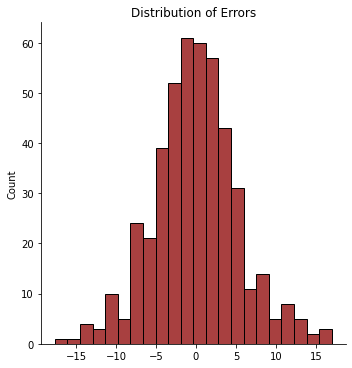

In [176]:
#obtain model residuals
final_model_residuals = final_model.resid

#plot residuals and find skew
sns.displot(final_model_residuals,kde = False, color = "darkred").set(title = "Distribution of Errors")
print("Skewness: ", final_model_residuals.skew())

The final model contains 2 less regressors than the last one and the same $R^2$ (0.85). 13 statistically significant regressors exist, compared to 11 previously.  **Pct2013ActParticipation** and **PctClass2013SATParticipaton** are statistically significant (P-value = 1.8e-08 and P-value = 0.1), which helps in answering question. We can infer that a 1 percentage point rise in seniors taking the ACT at a high school will lead to about a 0.23 increase in the percentage of high school students who graduate from college at least six years after high school, while a 1 percentage point rise in seniors taking the SAT at a high school will lead to a 0.07 increase. Therefore, we can conclude that **the ACT exam leads to more long term success for high school students.**

---

### Possible Extensions and Limitations Of This Study


A limitation of my study was that not all the high school data came from 2011. Some data came from the following years, and might not be representative of the high school environments the class of 2011 lived in. There were empty observations, and my data sample was limited to the state of Ohio.

An extension would be to do this same study in a few years with students who graduated high school during or after the COVID-19 Pandemic. Colleges dropped standardized test requirements for applicants, transforming the admissions landscape drastically. Does taking the SAT or ACT still have a major effect on long term success like it did before COVID-19?

---